In [1]:
import numpy as np
import cv2 as cv
import mediapipe as mp
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [2]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True,
                                max_num_hands=1,
                                min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

splits=['train','val','hold']

Handedness: [classification {
  index: 1
  score: 0.9825019
  label: "Right"
}
]
hand_landmarks: landmark {
  x: 0.32671586
  y: 0.4647864
  z: -5.9629656e-07
}
landmark {
  x: 0.2612645
  y: 0.43265206
  z: -0.0069826455
}
landmark {
  x: 0.22005129
  y: 0.37721178
  z: -0.009085217
}
landmark {
  x: 0.2150775
  y: 0.31264246
  z: -0.015516032
}
landmark {
  x: 0.23879683
  y: 0.27819878
  z: -0.020281669
}
landmark {
  x: 0.26659784
  y: 0.3194964
  z: 0.0149175115
}
landmark {
  x: 0.2612652
  y: 0.2720604
  z: -0.004575711
}
landmark {
  x: 0.2583591
  y: 0.31103542
  z: -0.017470943
}
landmark {
  x: 0.2615506
  y: 0.34027445
  z: -0.023311486
}
landmark {
  x: 0.30308554
  y: 0.3214162
  z: 0.007939605
}
landmark {
  x: 0.29806933
  y: 0.26706567
  z: -0.015171801
}
landmark {
  x: 0.2937414
  y: 0.32522175
  z: -0.022626856
}
landmark {
  x: 0.29710945
  y: 0.36395672
  z: -0.0210196
}
landmark {
  x: 0.33787405
  y: 0.32688752
  z: -0.0029627772
}
landmark {
  x: 0.33115074
  y

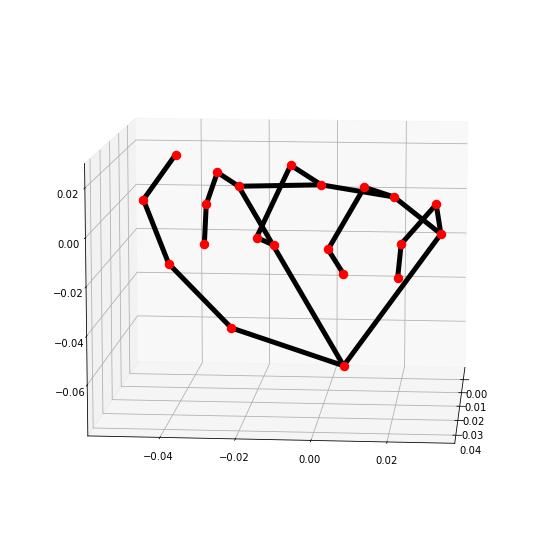

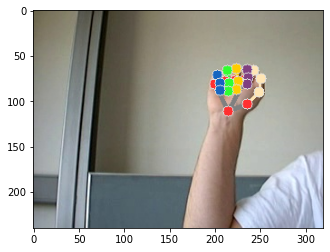

In [3]:
# script after google
file = "temp/A0.jpg"

# mpHands expects images to come reversed, like a selfie in a mirror.
image = cv.flip(cv.imread(file), 1)
results = hands.process(cv.cvtColor(image, cv.COLOR_BGR2RGB))   #OpenCV uses BGR by default, mpHands wants RGB

if not results.multi_hand_landmarks:
    print("Hand not detected: " + file)
else:    
    print('Handedness:', results.multi_handedness)
    image_height, image_width, _ = image.shape
    annotated_image = image.copy()
    for hand_landmarks in results.multi_hand_landmarks:
        # this section prints out the position of each hand landmark, if you want to know them
        print('hand_landmarks:', hand_landmarks)        
        print(
             f'Index finger tip coordinates: (',
             f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width}, '
             f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_height})'
            )
        mp_drawing.draw_landmarks(
          annotated_image,
          hand_landmarks,
          mp_hands.HAND_CONNECTIONS,
          mp_drawing_styles.get_default_hand_landmarks_style(),
          mp_drawing_styles.get_default_hand_connections_style())       
    if results.multi_hand_world_landmarks:
        for hand_world_landmarks in results.multi_hand_world_landmarks:
            mp_drawing.plot_landmarks(
              hand_world_landmarks, mp_hands.HAND_CONNECTIONS, azimuth=5)
            
    plt.imshow(cv.cvtColor( cv.flip(annotated_image, 1), cv.COLOR_BGR2RGB))   # pyplot expects RGB too

In [ ]:
# Landmark atlas: see https://google.github.io/mediapipe/solutions/hands
# the landmarks start at the wrist and move to the end of each finger in turn:
# wrist: 0
# thumb: 1, 2, 3, 4
# index: 5, 6, 7, 8
# middle: 9, 10, 11, 12
# ring: 13, 14, 15, 16
# small: 17, 18, 19, 20
# so for example the palm is represented by the marks 0, 5, 9, 13, 17

In [3]:
# put the hand landmark data in non-google-mystery-storage-object
def copy_landmarks_to_array(landmarks, array):
    for j in range(0,21):
        array[j][0] = landmarks._values[j].x
        array[j][1] = landmarks._values[j].y
        array[j][2] = landmarks._values[j].z
        
def get_handedness(hands_results):
    return hands_results.multi_handedness[0].classification._values[0].label
        
# transforms left hands into mirrored right hand position
# (curiously, mpHands exhibited chirality in some of our cropped images!)
def transform_handedness(array):
    array[:,0] = -array[:,0]+1
    return array

def plot_hands(hand1, hand2=None, figsize = (10,10)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection='3d')
    ax.scatter(hand1[:,0], hand1[:,1], hand1[:,2], marker='o')
    try:
        ax.scatter(hand2[:,0], hand2[:,1], hand2[:,2], marker='^')
    except:
        print(Excepted)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

def cross_product(v,w):
    return np.array([v[1]*w[2]-v[2]*w[1], v[2]*w[0]-v[0]*w[2], v[0]*w[1]-v[1]*w[0]])

from math import sqrt

# currently the normalised hands have the wrist at the origin, the triangle it makes with the knuckles of the 
# index and middle in the plane z = 0, and the x-axis bisecting that triangle
# in particular, this does not account for variable hand geometry
def normalise_hand_position(arrayIn):
    temp = np.array([[arrayIn[0,0], arrayIn[0,1], arrayIn[0,2]]]*21)
    arrayOut = arrayIn - temp
    if list(arrayOut[5,:]) == [0,0,0] or list(arrayOut[9,:]) == [0,0,0]:
        return arrayIn
    u1 = arrayOut[5,:] / np.linalg.norm(arrayOut[5,:])
    u2 = arrayOut[9,:] / np.linalg.norm(arrayOut[9,:])
    cross = cross_product(u1, u2)
    cross2 = cross_product(cross, u1)
    rotM = np.linalg.inv([(u1+u2)/sqrt(2), cross2, cross])
    return arrayOut.dot(rotM)
    
# moves a hand so its landmarks' centroid is at the origin. in tests kNN worked much worse this way.
def center_hand(array):
    temp = np.ones(array.shape[0])
    center = array.mean(axis=0)
    array[:,0] -= center[0] * temp
    array[:,1] -= center[1] * temp
    array[:,2] -= center[2] * temp

In [4]:
images = {}
labels = {}
for key in splits:
    images[key] = np.load("datasets/" + key + "_img_64.npy")
    labels[key] = np.load("datasets/" + key + "_lbl_64.npy")

In [5]:
def model_hands_from_dataset(img_dataset, normalise = True):
    hands_obt = np.zeros((len(img_dataset),21,3))
    success_list=[]    
    for j,image in enumerate(img_dataset):
        results = hands.process(image)
        if not results.multi_hand_landmarks:        
            results = hands.process(cv.flip(image,1))
        if results.multi_hand_landmarks:       
            copy_landmarks_to_array(results.multi_hand_landmarks[0].landmark,hands_obt[j])
            if results.multi_handedness[0].classification._values[0].label == 'Left':
                transform_handedness(hands_obt[j])
            if normalise:
                hands_obt[j] = normalise_hand_position(hands_obt[j])
            success_list.append(j)
    return hands_obt, success_list

In [6]:
# geom_full has the same length as images, with a list of co-ordinates in the indices the detector found them, zeros elsewhere
# indices has the positions where geom_full is not zero
geom_full = {}
indices = {}
for key in splits:
    geom_full[key], indices[key] = model_hands_from_dataset(images[key])
    
# geom has the hand co-ordinates with the zero entries removed
# geom_lbl has the corresponding labels in an array of the same size
geom = {}
geom_lbl = {}
for key in splits:
    geom[key] = geom_full[key][indices[key]]
    geom_lbl[key] = labels[key][indices[key]]
    print(key, geom_lbl[key].shape, labels[key].shape)    

train (20467,) (25303,)
val (3488,) (5147,)
hold (3268,) (4186,)


In [7]:
for key in splits:
    np.save("datasets/" + key + "_geom_full.npy", geom_full[key])
    np.save("datasets/" + key + "_geom.npy", geom[key])
    np.save("datasets/" + key + "_geom_lbl.npy", geom_lbl[key])
    np.save("datasets/bak/" + key + "_geom_indices.npy", indices)

In [12]:
from sklearn.neighbors import KNeighborsClassifier

In [13]:
# flatten arrays
for key in splits:
    geom[key] = geom[key].reshape(geom[key].shape[0], 63)

In [15]:
for k in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors = k, n_jobs=-1, weights='distance')
    knn.fit(geom['train'], geom_lbl['train'])
    print(k, knn.score(geom['val'], geom_lbl['val']))

1 0.7859190254389108
2 0.7859190254389108
3 0.7843067001074884
4 0.7873522035112863
5 0.7828735220351128
6 0.7862773199570047
7 0.7846649946255823
8 0.7828735220351128
9 0.7800071658903619


In [46]:
# compare: accuracy on the training data (without distance weights)
for k in range(2,10):
    knn = KNeighborsClassifier(n_neighbors = k, n_jobs=-1)
    knn.fit(geom['train'], geom_lbl['train'])
    print(knn.score(geom['train', geom_lbl['train']))

0.9540492170022371
0.9487248322147651
0.9341834451901566
0.9289485458612975
0.9214765100671141
0.9175838926174497
0.9113646532438479
0.9076062639821029


In [17]:
import tensorflow as tf

In [40]:
# a NN can do better; I've seen over 0.86 val accuracy with architectures like this one, although
# they do take a while to get there
geomModel = tf.keras.models.Sequential([tf.keras.layers.Dense(256, activation='relu'),
                                       tf.keras.layers.Dense(256, activation='relu'), 
                                       tf.keras.layers.Dense(256, activation='relu'), 
                                       tf.keras.layers.Dense(50, activation='softmax')])

In [41]:
learning_rate=0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                    learning_rate,
                    decay_steps=5000,
                    decay_rate=0.9,
                    staircase=True)

geomModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

In [45]:
# This does the same thing as
# geomModel.fit(train_hand_geom, train_hand_lbl, validation_data=(val_hand, val_lbl), epochs=epochs)
# but with better formatting (fit was giving me line breaks in the middle of val_accuracy, of all the places)
epochs = 10
for j in range(0, epochs):
    geomModel.fit(geom['train'], geom_lbl['train'], epochs=1)
    geomModel.evaluate(geom['val'], geom_lbl['val'], verbose=2)

699/699 [==============================] - 1s 2ms/step - loss: 0.2354 - accuracy: 0.9299
175/175 - 0s - loss: 0.6752 - accuracy: 0.8382 - 161ms/epoch - 918us/step
699/699 [==============================] - 1s 2ms/step - loss: 0.2347 - accuracy: 0.9291
175/175 - 0s - loss: 0.6953 - accuracy: 0.8341 - 172ms/epoch - 984us/step
699/699 [==============================] - 1s 2ms/step - loss: 0.2343 - accuracy: 0.9309
175/175 - 0s - loss: 0.6827 - accuracy: 0.8354 - 168ms/epoch - 961us/step
699/699 [==============================] - 1s 2ms/step - loss: 0.2335 - accuracy: 0.9302
175/175 - 0s - loss: 0.6831 - accuracy: 0.8382 - 160ms/epoch - 915us/step
699/699 [==============================] - 1s 2ms/step - loss: 0.2332 - accuracy: 0.9312
175/175 - 0s - loss: 0.6821 - accuracy: 0.8354 - 166ms/epoch - 949us/step
699/699 [==============================] - 1s 2ms/step - loss: 0.2320 - accuracy: 0.9305
175/175 - 0s - loss: 0.6945 - accuracy: 0.8325 - 168ms/epoch - 961us/step
699/699 [=============